✅ All libraries imported successfully!

LOADING COMPAS DATASET
Dataset shape: (7214, 53)

First few rows:
   id                name   first         last compas_screening_date   sex  \
0   1    miguel hernandez  miguel    hernandez            2013-08-14  Male   
1   3         kevon dixon   kevon        dixon            2013-01-27  Male   
2   4            ed philo      ed        philo            2013-04-14  Male   
3   5         marcu brown   marcu        brown            2013-01-13  Male   
4   6  bouthy pierrelouis  bouthy  pierrelouis            2013-03-26  Male   

          dob  age          age_cat              race  ...  v_decile_score  \
0  1947-04-18   69  Greater than 45             Other  ...               1   
1  1982-01-22   34          25 - 45  African-American  ...               1   
2  1991-05-14   24     Less than 25  African-American  ...               3   
3  1993-01-21   23     Less than 25  African-American  ...               6   
4  1973-01-22   43          25 - 45

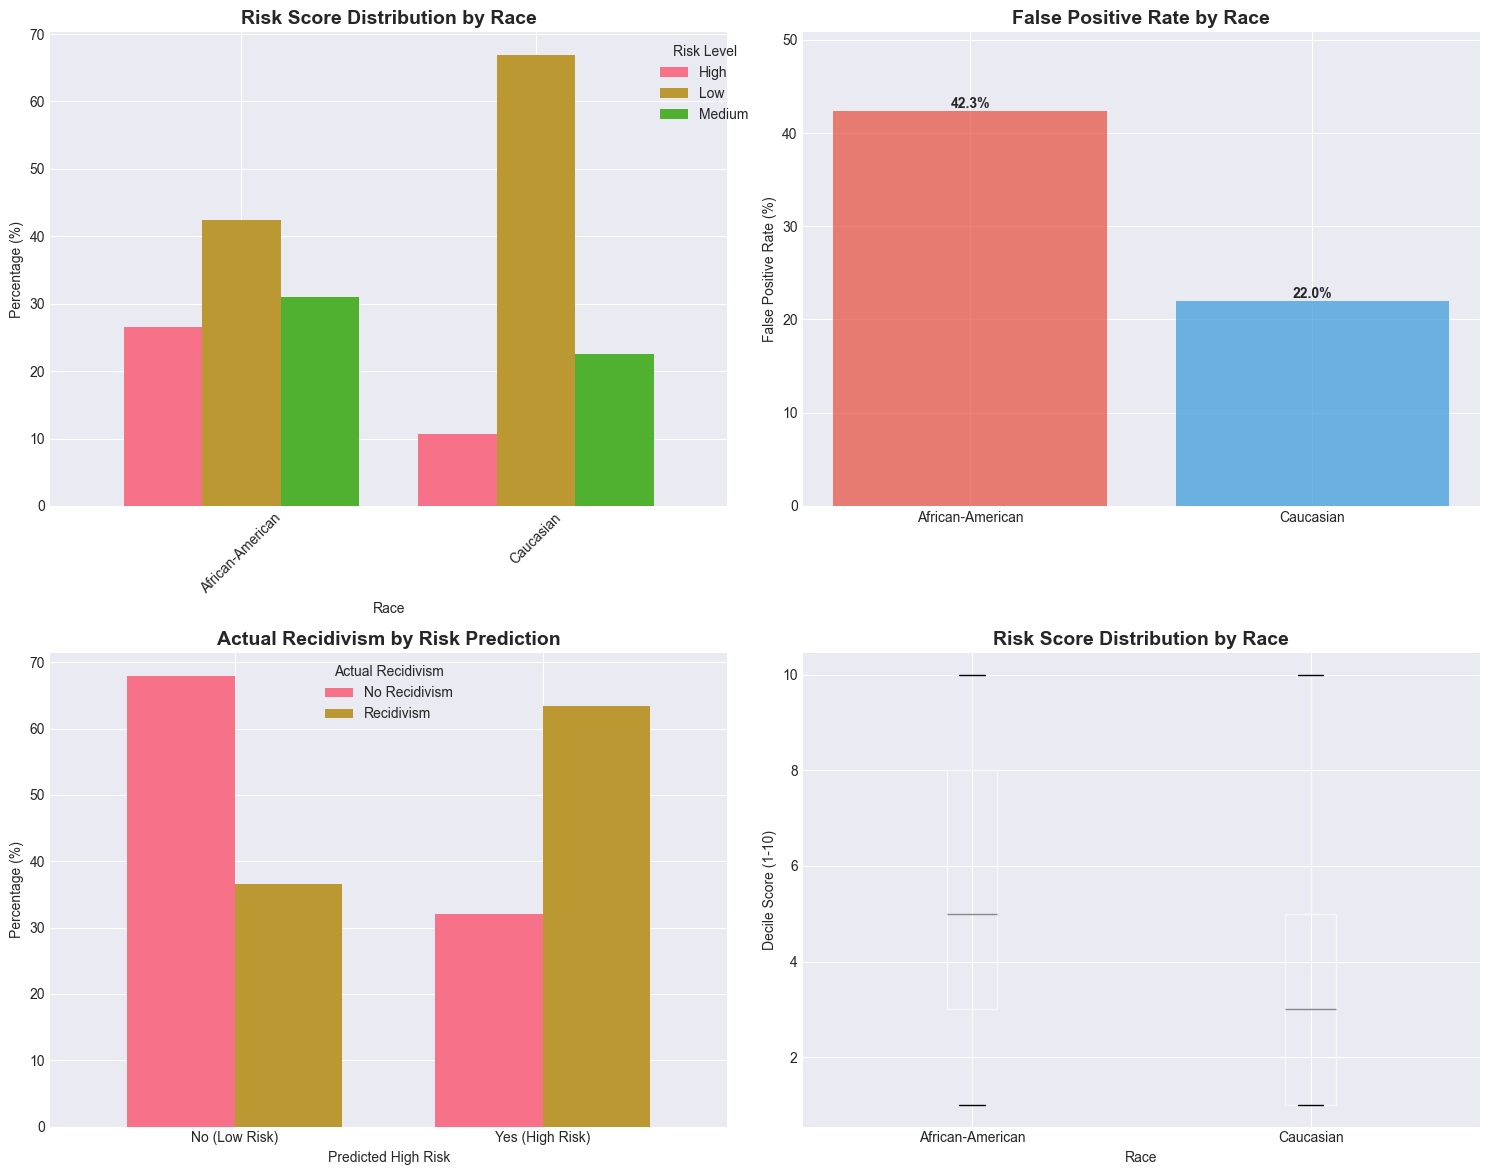


BIAS MITIGATION - REWEIGHING ALGORITHM
Fairness Metrics After Reweighing:
  Statistical Parity Difference: 0.0000
  Disparate Impact Ratio: 1.0000

✅ Improvement: Closer to 1.0 indicates reduced bias

FAIRNESS AUDIT SUMMARY REPORT

COMPAS RECIDIVISM ALGORITHM BIAS AUDIT
Generated: 2025-12-01 11:08:27

DATASET OVERVIEW:
- Total Records Analyzed: 5,278
- African-American: 3,175 (60.2%)
- Caucasian: 2,103 (39.8%)

KEY FINDINGS:

1. ALGORITHMIC BIAS DETECTED:
   - African-Americans are labeled high risk at 57.6%
   - Caucasians are labeled high risk at 33.1%
   - Disparity: 24.5% points

2. FALSE POSITIVE RATE DISPARITY:
   - African-Americans: 42.3% (incorrectly labeled high risk)
   - Caucasians: 22.0% (incorrectly labeled high risk)
   - ⚠️ African-Americans are 1.92x more likely
      to be incorrectly labeled high risk

3. FAIRNESS METRICS:
   - Disparate Impact Ratio: 0.7828
     (Fair range: 0.8 - 1.2; Current value indicates bias)
   - Statistical Parity Difference: -0.1323
     (

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# AI Fairness 360 imports
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

# ============================================================================
# STEP 2: LOAD AND EXPLORE DATA
print("\n" + "="*80)
print("LOADING COMPAS DATASET")
print("="*80)

# Load the COMPAS dataset (download if not present)
csv_path = 'compas-scores-two-years.csv'
if not os.path.exists(csv_path):
    print(f"'{csv_path}' not found. Attempting to download from the ProPublica repository...")
    url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
    try:
        import urllib.request
        urllib.request.urlretrieve(url, csv_path)
        print("Download completed successfully.")
    except Exception as e:
        raise FileNotFoundError(
            f"Could not find '{csv_path}' locally and automatic download failed.\n"
            f"Please download the file manually from:\n  {url}\n"
            f"and place it in the working directory. Original error: {e}"
        )

df = pd.read_csv(csv_path)
df = pd.read_csv('compas-scores-two-years.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

# Data preprocessing
print("\n" + "="*80)
print("DATA PREPROCESSING")
print("="*80)

# Select relevant columns
columns_to_keep = [
    'age', 'c_charge_degree', 'race', 'age_cat', 'score_text',
    'sex', 'priors_count', 'days_b_screening_arrest', 'decile_score',
    'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out'
]

df_clean = df[columns_to_keep].copy()

# Filter data (standard COMPAS analysis filters)
df_clean = df_clean[
    (df_clean['days_b_screening_arrest'] <= 30) &
    (df_clean['days_b_screening_arrest'] >= -30) &
    (df_clean['is_recid'] != -1) &
    (df_clean['c_charge_degree'] != 'O') &
    (df_clean['score_text'] != 'N/A')
]

# Create binary risk score (High/Medium = 1, Low = 0)
df_clean['high_risk'] = (df_clean['score_text'].isin(['High', 'Medium'])).astype(int)

# Encode race as binary (African-American vs Caucasian for primary analysis)
df_clean = df_clean[df_clean['race'].isin(['African-American', 'Caucasian'])]
df_clean['race_binary'] = (df_clean['race'] == 'African-American').astype(int)

print(f"Cleaned dataset shape: {df_clean.shape}")
print(f"\nRace distribution:")
print(df_clean['race'].value_counts())
print(f"\nRecidivism rate: {df_clean['two_year_recid'].mean():.2%}")

# ============================================================================
# STEP 3: INITIAL BIAS ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("INITIAL BIAS ANALYSIS")
print("="*80)

# Risk score distribution by race
print("\nRisk Score Distribution by Race:")
risk_by_race = pd.crosstab(
    df_clean['race'],
    df_clean['score_text'],
    normalize='index'
) * 100
print(risk_by_race.round(2))

# High risk classification rates
high_risk_by_race = df_clean.groupby('race')['high_risk'].mean()
print(f"\n% Labeled High Risk:")
for race, rate in high_risk_by_race.items():
    print(f"  {race}: {rate:.2%}")

# ============================================================================
# STEP 4: CONFUSION MATRIX ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("CONFUSION MATRIX ANALYSIS BY RACE")
print("="*80)

def analyze_confusion_matrix(data, race_name):
    """Calculate confusion matrix metrics for a specific race"""
    y_true = data['two_year_recid']
    y_pred = data['high_risk']
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate
    
    return {
        'race': race_name,
        'true_negative': tn,
        'false_positive': fp,
        'false_negative': fn,
        'true_positive': tp,
        'false_positive_rate': fpr,
        'false_negative_rate': fnr,
        'total': len(data)
    }

# Analyze both racial groups
aa_metrics = analyze_confusion_matrix(
    df_clean[df_clean['race'] == 'African-American'],
    'African-American'
)
cauc_metrics = analyze_confusion_matrix(
    df_clean[df_clean['race'] == 'Caucasian'],
    'Caucasian'
)

metrics_df = pd.DataFrame([aa_metrics, cauc_metrics])
print("\nConfusion Matrix Metrics:")
print(metrics_df.to_string(index=False))

print(f"\n⚠️  FALSE POSITIVE RATE DISPARITY:")
print(f"   African-American: {aa_metrics['false_positive_rate']:.2%}")
print(f"   Caucasian: {cauc_metrics['false_positive_rate']:.2%}")
print(f"   Difference: {(aa_metrics['false_positive_rate'] - cauc_metrics['false_positive_rate']):.2%}")

# ============================================================================
# STEP 5: AI FAIRNESS 360 METRICS
# ============================================================================
print("\n" + "="*80)
print("AI FAIRNESS 360 BIAS METRICS")
print("="*80)

# Prepare data for AIF360
df_aif = df_clean[['race_binary', 'high_risk', 'two_year_recid', 'priors_count', 'age']].copy()

# Create BinaryLabelDataset
dataset = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=df_aif,
    label_names=['two_year_recid'],
    protected_attribute_names=['race_binary']
)

# Calculate fairness metrics
privileged_groups = [{'race_binary': 0}]  # Caucasian
unprivileged_groups = [{'race_binary': 1}]  # African-American

metric = BinaryLabelDatasetMetric(
    dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print("Key Fairness Metrics:")
print(f"  Statistical Parity Difference: {metric.statistical_parity_difference():.4f}")
print(f"  Disparate Impact Ratio: {metric.disparate_impact():.4f}")
print(f"  (Ratio < 0.8 or > 1.2 indicates bias)")

# ============================================================================
# STEP 6: VISUALIZATIONS
# ============================================================================
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Risk Score Distribution
risk_dist = df_clean.groupby(['race', 'score_text']).size().unstack(fill_value=0)
risk_dist_pct = risk_dist.div(risk_dist.sum(axis=1), axis=0) * 100
risk_dist_pct.plot(kind='bar', ax=axes[0, 0], width=0.8)
axes[0, 0].set_title('Risk Score Distribution by Race', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Race')
axes[0, 0].set_ylabel('Percentage (%)')
axes[0, 0].legend(title='Risk Level', bbox_to_anchor=(1.05, 1))
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45)

# Plot 2: False Positive Rate Comparison
fpr_data = pd.DataFrame({
    'Race': ['African-American', 'Caucasian'],
    'False Positive Rate': [
        aa_metrics['false_positive_rate'],
        cauc_metrics['false_positive_rate']
    ]
})
bars = axes[0, 1].bar(fpr_data['Race'], fpr_data['False Positive Rate'] * 100, 
                       color=['#e74c3c', '#3498db'], alpha=0.7)
axes[0, 1].set_title('False Positive Rate by Race', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('False Positive Rate (%)')
axes[0, 1].set_ylim(0, max(fpr_data['False Positive Rate']) * 120)
for bar in bars:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 3: Recidivism vs Prediction
recid_pred = pd.crosstab(
    df_clean['two_year_recid'],
    df_clean['high_risk'],
    normalize='columns'
) * 100
recid_pred.plot(kind='bar', ax=axes[1, 0], width=0.7)
axes[1, 0].set_title('Actual Recidivism by Risk Prediction', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Predicted High Risk')
axes[1, 0].set_ylabel('Percentage (%)')
axes[1, 0].set_xticklabels(['No (Low Risk)', 'Yes (High Risk)'], rotation=0)
axes[1, 0].legend(title='Actual Recidivism', labels=['No Recidivism', 'Recidivism'])

# Plot 4: Decile Score Distribution
df_clean.boxplot(column='decile_score', by='race', ax=axes[1, 1])
axes[1, 1].set_title('Risk Score Distribution by Race', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Race')
axes[1, 1].set_ylabel('Decile Score (1-10)')
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.savefig('compas_bias_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Visualizations saved as 'compas_bias_analysis.png'")
plt.show()

# ============================================================================
# STEP 7: BIAS MITIGATION (REWEIGHING)
# ============================================================================
print("\n" + "="*80)
print("BIAS MITIGATION - REWEIGHING ALGORITHM")
print("="*80)

# Apply reweighing
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transformed = RW.fit_transform(dataset)

# Calculate metrics after mitigation
metric_transformed = BinaryLabelDatasetMetric(
    dataset_transformed,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print("Fairness Metrics After Reweighing:")
print(f"  Statistical Parity Difference: {metric_transformed.statistical_parity_difference():.4f}")
print(f"  Disparate Impact Ratio: {metric_transformed.disparate_impact():.4f}")
print(f"\n✅ Improvement: Closer to 1.0 indicates reduced bias")

# ============================================================================
# STEP 8: SUMMARY REPORT
# ============================================================================
print("\n" + "="*80)
print("FAIRNESS AUDIT SUMMARY REPORT")
print("="*80)

report = f"""
COMPAS RECIDIVISM ALGORITHM BIAS AUDIT
Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

DATASET OVERVIEW:
- Total Records Analyzed: {len(df_clean):,}
- African-American: {(df_clean['race'] == 'African-American').sum():,} ({(df_clean['race'] == 'African-American').mean():.1%})
- Caucasian: {(df_clean['race'] == 'Caucasian').sum():,} ({(df_clean['race'] == 'Caucasian').mean():.1%})

KEY FINDINGS:

1. ALGORITHMIC BIAS DETECTED:
   - African-Americans are labeled high risk at {high_risk_by_race['African-American']:.1%}
   - Caucasians are labeled high risk at {high_risk_by_race['Caucasian']:.1%}
   - Disparity: {(high_risk_by_race['African-American'] - high_risk_by_race['Caucasian']):.1%} points

2. FALSE POSITIVE RATE DISPARITY:
   - African-Americans: {aa_metrics['false_positive_rate']:.1%} (incorrectly labeled high risk)
   - Caucasians: {cauc_metrics['false_positive_rate']:.1%} (incorrectly labeled high risk)
   - ⚠️ African-Americans are {(aa_metrics['false_positive_rate'] / cauc_metrics['false_positive_rate']):.2f}x more likely
      to be incorrectly labeled high risk

3. FAIRNESS METRICS:
   - Disparate Impact Ratio: {metric.disparate_impact():.4f}
     (Fair range: 0.8 - 1.2; Current value indicates bias)
   - Statistical Parity Difference: {metric.statistical_parity_difference():.4f}
     (Optimal: 0.0; Current value shows unfairness)

REMEDIATION RECOMMENDATIONS:

1. DATA REBALANCING:
   - Collect more diverse training data
   - Ensure equal representation across racial groups
   - Address historical biases in arrest/conviction data

2. ALGORITHMIC INTERVENTION:
   - Apply fairness-aware preprocessing (e.g., reweighing)
   - Use adversarial debiasing techniques
   - Implement post-processing calibration

3. POLICY CHANGES:
   - Require human review for all high-risk classifications
   - Establish regular bias audits (quarterly)
   - Create appeals process for disputed risk scores
   - Prohibit use as sole decision-making factor

4. MONITORING:
   - Track false positive rates by demographic group monthly
   - Set fairness thresholds (Disparate Impact > 0.8)
   - Conduct intersectional analysis (race + gender + age)

CONCLUSION:
The COMPAS algorithm exhibits significant racial bias, disproportionately harming
African-American defendants. Immediate intervention required before continued deployment.
"""

print(report)

# Save report to file
with open('fairness_audit_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print("\n✅ Full report saved as 'fairness_audit_report.txt'")
print("\n" + "="*80)
print("AUDIT COMPLETE - All analyses finished successfully!")
print("="*80)